In [1]:
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
from datasets import Dataset

c:\Users\vince\miniconda3\envs\radio_sunburst_labelcreation\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
images = glob.glob('C:/Users/vince/FlareSense-v2/*/*/*.png')
images = [x.replace('\\', '/') for x in images]

In [3]:
images[0]

'C:/Users/vince/FlareSense-v2/test_images/0/0_Australia-ASSA_62_2023-12-21_21_22_00.png'

In [4]:
df = pd.DataFrame()

In [5]:
df

""


In [6]:
df['image'] = images
df['label'] = df['image'].str.split('/', expand=True)[5].astype(int)
df['filename'] = df['image'].str.split('/', expand=True)[6]
df['antenna'] = df['image'].str.split('/', expand=True)[6].str.split('_', expand=True)[1] + '_' + df['image'].str.split('/', expand=True)[6].str.split('_', expand=True)[2]
df['datetime'] = df['image'].str.split('/', expand=True)[6].str.split('_', expand=True)[3] + ' ' + df['image'].str.split('/', expand=True)[6].str.split('_', expand=True)[4] + ':' + df['image'].str.split('/', expand=True)[6].str.split('_', expand=True)[5]
df['datetime'] = pd.to_datetime(df['datetime'])


In [7]:
train_df, val_df, test_df = df[df.image.str.contains('train_images')],  df[df.image.str.contains('val_images')], df[df.image.str.contains('test_images')]

In [8]:
def assert_no_overlap_and_drop(train_df, val_df, test_df):
    train_files = set(train_df['filename'])
    val_files = set(val_df['filename'])
    test_files = set(test_df['filename'])

    overlap_train_val = train_files.intersection(val_files)
    overlap_train_test = train_files.intersection(test_files)

    if overlap_train_val:
        print(f"Dropping {len(overlap_train_val)} items from Train set due to overlap with Validation set.")
        # Drop overlapping entries from train_df
        train_df = train_df[~train_df['filename'].isin(overlap_train_val)]
    else:
        print("No overlap between Train and Validation sets.")
    
    if overlap_train_test:
        print(f"Dropping {len(overlap_train_test)} items from Train set due to overlap with Test set.")
        # Drop overlapping entries from train_df
        train_df = train_df[~train_df['filename'].isin(overlap_train_test)]
    else:
        print("No overlap between Train and Test sets.")
    
    # Checking overlap between Validation and Test sets remains the same since we don't modify these dataframes here
    overlap_val_test = val_files.intersection(test_files)
    if overlap_val_test:
        print(f"Overlap between Validation and Test sets: {overlap_val_test}")
        val_df = val_df[~val_df['filename'].isin(overlap_val_test)]
    else:
        print("No overlap between Validation and Test sets.")
    
    return train_df, val_df, test_df

# Perform the assertion check and drop overlaps
train_df, val_df, test_df = assert_no_overlap_and_drop(train_df, val_df, test_df)


No overlap between Train and Validation sets.
Dropping 1 items from Train set due to overlap with Test set.
Overlap between Validation and Test sets: {'999_GLASGOW_01_2023-08-08_09_27_00.png'}


In [9]:
train_df.to_csv('C:/Users/vince/FlareSense-v2/train_metadata.csv', index=False)
test_df.to_csv('C:/Users/vince/FlareSense-v2/test_metadata.csv', index=False)
val_df.to_csv('C:/Users/vince/FlareSense-v2/val_metadata.csv', index=False)

C:\Users\vince\AppData\Local\Temp\ipykernel_32868\2707482047.py:10: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  date_range_per_antenna = val_df.groupby('antenna')['datetime'].agg([min, max])
C:\Users\vince\AppData\Local\Temp\ipykernel_32868\2707482047.py:10: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  date_range_per_antenna = val_df.groupby('antenna')['datetime'].agg([min, max])


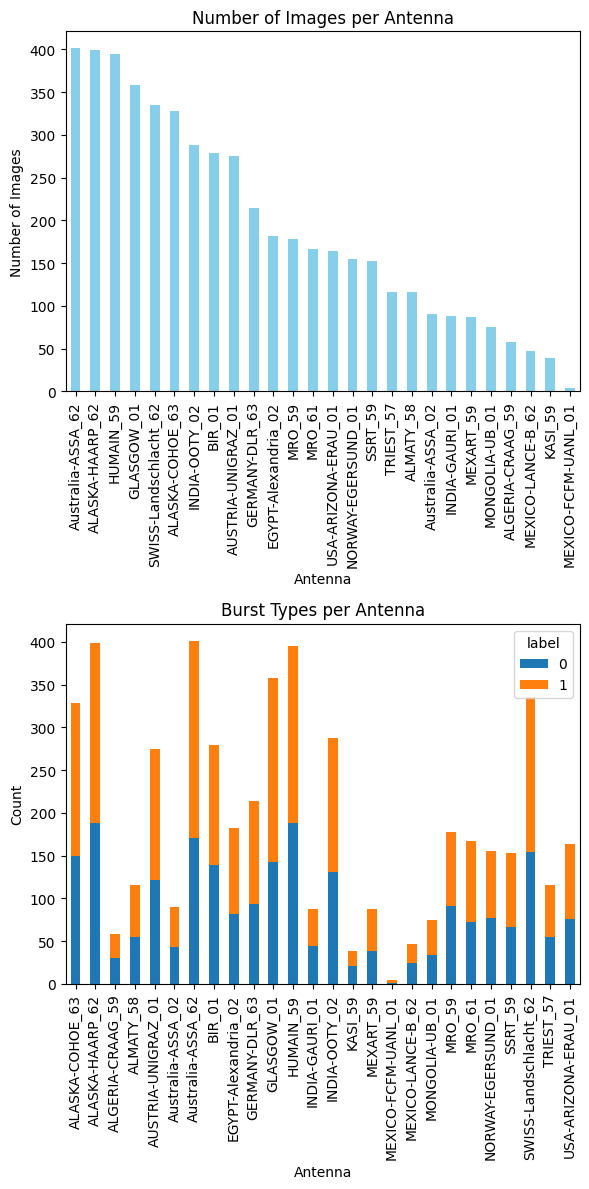

In [10]:
# EDA
import matplotlib.pyplot as plt
# Number of images per antenna
images_per_antenna = val_df['antenna'].value_counts()

# Number of burst types per antenna
burst_types_per_antenna = val_df.groupby('antenna')['label'].value_counts().unstack(fill_value=0)

# Date range per antenna
date_range_per_antenna = val_df.groupby('antenna')['datetime'].agg([min, max])

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(6, 12))

# Images per antenna
images_per_antenna.plot(kind='bar', ax=ax[0], color='skyblue')
ax[0].set_title('Number of Images per Antenna')
ax[0].set_xlabel('Antenna')
ax[0].set_ylabel('Number of Images')

# Burst types per antenna
burst_types_per_antenna.plot(kind='bar', stacked=True, ax=ax[1])
ax[1].set_title('Burst Types per Antenna')
ax[1].set_xlabel('Antenna')
ax[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [11]:
from datasets import load_dataset
train = load_dataset('csv', data_files='C:/Users/vince/FlareSense-v2/train_metadata.csv')
valid = load_dataset('csv', data_files='C:/Users/vince/FlareSense-v2/val_metadata.csv')
test = load_dataset('csv', data_files='C:/Users/vince/FlareSense-v2/test_metadata.csv')

Generating train split: 39097 examples [00:00, 376726.05 examples/s]
Generating train split: 4991 examples [00:00, 355895.47 examples/s]
Generating train split: 5076 examples [00:00, 294479.61 examples/s]


In [12]:
from datasets import Image
train = train.cast_column("image", Image())
valid = valid.cast_column("image", Image())
test = test.cast_column("image", Image())

In [13]:
from datasets import DatasetDict
dd = DatasetDict({"train": train['train'],"validation": valid['train'], "test":test['train']})

In [14]:
dd

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'filename', 'antenna', 'datetime'],
        num_rows: 39097
    })
    validation: Dataset({
        features: ['image', 'label', 'filename', 'antenna', 'datetime'],
        num_rows: 4991
    })
    test: Dataset({
        features: ['image', 'label', 'filename', 'antenna', 'datetime'],
        num_rows: 5076
    })
})

In [16]:
import os
os.environ['HF_TOKEN'] = 

In [17]:
dd.push_to_hub('i4ds/radio-sunburst-ecallisto-binary-cleaned-3', private=False)

Uploading the dataset shards: 100%|██████████| 1/1 [00:05<00:00,  5.33s/it]
c:\Users\vince\miniconda3\envs\radio_sunburst_labelcreation\Lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\vince\.cache\huggingface\hub\datasets--i4ds--radio-sunburst-ecallisto-binary-cleaned-3. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  war

CommitInfo(commit_url='https://huggingface.co/datasets/i4ds/radio-sunburst-ecallisto-binary-cleaned-3/commit/e0fb4006beeebfabddaf4f8e1790b49fe44b03d9', commit_message='Upload dataset', commit_description='', oid='e0fb4006beeebfabddaf4f8e1790b49fe44b03d9', pr_url=None, pr_revision=None, pr_num=None)

In [18]:
dd['test']['label'][-1]

1

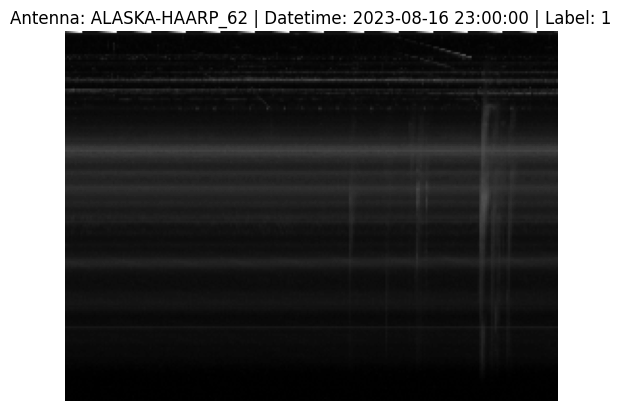

In [19]:
# Display the image
plt.imshow(dd['train'][35000]['image'], cmap='gray')  # 'gray' colormap for mode=L (grayscale)
plt.title(f"Antenna: {dd['train'][35000]['antenna']} | Datetime: {dd['train'][35000]['datetime']} | Label: {dd['train'][35000]['label']}")
plt.axis('off')  # Turn off the axis
plt.show()